# Benchmark

In [1]:
import numpy as np
import pandas as pd
from keras.utils import np_utils
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from ANN import ANN


Using TensorFlow backend.


## Prepare Dataset

In [2]:
datasetPath = "Dataset/balanced-74Attributes-top17_ProtocolName.csv"
df = pd.read_csv(datasetPath)
#df = pd.read_csv(datasetPath, nrows=1000000)
df.head()

,Source.IP,Source.Port,Destination.IP,Destination.Port,Protocol,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,Total.Length.of.Fwd.Packets,Total.Length.of.Bwd.Packets,...,Active.Mean,Active.Std,Active.Max,Active.Min,Idle.Mean,Idle.Std,Idle.Max,Idle.Min,L7Protocol,ProtocolName
0,3232238138,55681,180881158,3128,6,19002242,3,17,6,30.0,...,7352281.0,0.000000,7352281.0,7352281.0,11649832.0,0.000000e+00,11649832.0,11649832.0,131,HTTP_PROXY
1,180881160,3128,3232246304,53107,6,119684671,1006,898,1398550,5388.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,131,HTTP_PROXY
2,3232243804,59584,180881158,3128,6,118953292,24,66,1325,5077.0,...,336393.6,238675.043634,655083.0,172.0,23388871.8,7.972935e+06,29761260.0,12118217.0,131,HTTP_PROXY
3,182845710,53446,180881157,3128,6,59992665,3,3,18,63.0,...,120.0,91.923882,185.0,55.0,29995813.0,2.121108e+07,44994310.0,14997316.0,131,HTTP_PROXY
4,3232254003,21192,180881159,3128,6,1413924,22,0,4622,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,131,HTTP_PROXY


In [3]:
# Encode label for ProtocolName column

encoder = LabelEncoder().fit(df['ProtocolName'])
df['ProtocolName'] = encoder.fit_transform(df['ProtocolName'])

In [4]:
X = df.drop('ProtocolName',axis=1)
Y = df['ProtocolName']

scaler = StandardScaler()
X = scaler.fit_transform(X)


x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.7, random_state=42)

dummy_y = np_utils.to_categorical(Y)
x_train_ANN, x_test_ANN, y_train_ANN, y_test_ANN = train_test_split(X, dummy_y, train_size=0.7, random_state=42)

In [5]:
# crop test dataset for faster result

x_test = x_test[:10000]
y_test = y_test[:10000]

x_test_ANN = x_test_ANN[:10000]
y_test_ANN = y_test_ANN[:10000]

## Run Benchmark

In [23]:
classifiers = {"KNN": KNeighborsClassifier(n_neighbors = 3, metric='manhattan', weights='distance'),
               "RF": RandomForestClassifier(n_estimators=60),
               "SVM": SVC(),
               "ANN": ANN(x_train_ANN, x_test_ANN, y_train_ANN, y_test_ANN)}

## ram usages during training
# ANN --> peak memory: 1069.52 MiB, increment: 141.65 MiB
# KNN --> peak memory: 658.62 MiB, increment: 0.08 MiB
# SVM --> peak memory: 913.84 MiB, increment: 257.71 MiB
# RF  --> peak memory: 1181.21 MiB, increment: 538.25 MiB
peak memory: 1017.16 MiB, increment: 46.52 MiB

## ram usages during testing
# ANN --> peak memory: 950.79 MiB, increment: 23.89 MiB
# KNN --> peak memory: 2675.44 MiB, increment: 2016.64 MiB
# SVM --> peak memory: 914.21 MiB, increment: 0.01 MiB
# RF  --> peak memory: 1170.08 MiB, increment: 36.55 MiB
peak memory: 1017.39 MiB, increment: 0.12 MiB

results = {"KNN": {"accuracy": 0, "precision":0, "recall": 0, "f1": 0, "cm": None, 
                   "trainTime": 0, "runTime": 0, "trainRam": 0.08, "runTimeRam": 2016.64},
           "RF": {"accuracy": 0, "precision":0, "recall": 0, "f1": 0, "cm": None, 
                  "trainTime": 0, "runTime": 0, "trainRam": 538.25, "runTimeRam": 36.55},
           "SVM": {"accuracy": 0, "precision":0, "recall": 0, "f1": 0, "cm": None, 
                   "trainTime": 0, "runTime": 0, "trainRam": 257.71, "runTimeRam": 0.02},
           "ANN": {"accuracy": 0, "precision":0, "recall": 0, "f1": 0, "cm": None, 
                   "trainTime": 0, "runTime": 0, "trainRam": 141.65, "runTimeRam": 23.89}}

In [7]:
import time

for name in classifiers.keys():
    classifier = classifiers[name]
    if name == "ANN":
        t = time.time()
        classifier.fit(epochs=60)
        results[name]["trainTime"] = time.time()-t+1
        
        accuracy, precision, recall, f1, runTime = classifier.predict()
        results[name]["runTime"] = runTime+1
        
        cm = classifier.getConfusionMatrix(y_test)
        
        classifier.save("Models/ANN.h5")
    else:
        t = time.time()
        classifier.fit(x_train , y_train)
        results[name]["trainTime"] = time.time()-t+1
        
        t = time.time()
        y_pred = classifier.predict(x_test)
        results[name]["runTime"] = time.time()-t+1
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average="macro")
        recall = recall_score(y_test, y_pred, average="macro")
        f1 = f1_score(y_test, y_pred, average="macro")
        
        cm = confusion_matrix(y_test, y_pred)
        
        # now you can save it to a file
        with open("Models/" + name + ".pkl", 'wb') as f:
            pickle.dump(classifier, f)

    results[name]["accuracy"] = accuracy
    results[name]["precision"] = precision
    results[name]["recall"] = recall
    results[name]["f1"] = f1
    results[name]["cm"] = cm

Epoch 1/60
2692/2692 [==============================] - 4s 1ms/step - loss: 0.9708 - accuracy: 0.6722 - val_loss: 0.2795 - val_accuracy: 0.8983
Epoch 2/60
2692/2692 [==============================] - 3s 1ms/step - loss: 0.2467 - accuracy: 0.9087 - val_loss: 0.1404 - val_accuracy: 0.9505
Epoch 3/60
2692/2692 [==============================] - 3s 1ms/step - loss: 0.1651 - accuracy: 0.9391 - val_loss: 0.1183 - val_accuracy: 0.9585
Epoch 4/60
2692/2692 [==============================] - 3s 1ms/step - loss: 0.1224 - accuracy: 0.9557 - val_loss: 0.0950 - val_accuracy: 0.9659
Epoch 5/60
2692/2692 [==============================] - 3s 1ms/step - loss: 0.0998 - accuracy: 0.9630 - val_loss: 0.1163 - val_accuracy: 0.9530
Epoch 6/60
2692/2692 [==============================] - 3s 1ms/step - loss: 0.0913 - accuracy: 0.9668 - val_loss: 0.0922 - val_accuracy: 0.9622
Epoch 7/60
2692/2692 [==============================] - 3s 1ms/step - loss: 0.0853 - accuracy: 0.9683 - val_loss: 0.0612 - val_accuracy:

2692/2692 [==============================] - 3s 1ms/step - loss: 0.0216 - accuracy: 0.9937 - val_loss: 0.0179 - val_accuracy: 0.9949
Epoch 58/60
2692/2692 [==============================] - 3s 1ms/step - loss: 0.0274 - accuracy: 0.9948 - val_loss: 0.0565 - val_accuracy: 0.9881
Epoch 59/60
2692/2692 [==============================] - 3s 1ms/step - loss: 0.0235 - accuracy: 0.9940 - val_loss: 0.0338 - val_accuracy: 0.9932
Epoch 60/60
2692/2692 [==============================] - 3s 1ms/step - loss: 0.0209 - accuracy: 0.9938 - val_loss: 0.0201 - val_accuracy: 0.9963
313/313 - 0s - loss: 0.0201 - accuracy: 0.9963


## Results

### Accuracy - Precision - Recall - F1 Analysis

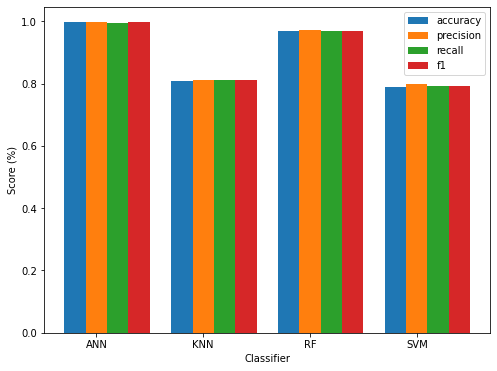

Classifier      accuracy(%)    precision(%)    recall(%)    f1 (%)
------------  -------------  --------------  -----------  --------
ANN                  0.9963        0.996897     0.9958    0.996348
KNN                  0.807         0.811449     0.810176  0.810444
RF                   0.9695        0.970436     0.969805  0.969997
SVM                  0.7892        0.799931     0.793198  0.792161


In [15]:
x = ["ANN", "KNN", "RF", "SVM"]
accuracy = [results["ANN"]["accuracy"], results["KNN"]["accuracy"], results["RF"]["accuracy"], results["SVM"]["accuracy"]]
precision = [results["ANN"]["precision"], results["KNN"]["precision"], results["RF"]["precision"], results["SVM"]["precision"]]
recall = [results["ANN"]["recall"], results["KNN"]["recall"], results["RF"]["recall"], results["SVM"]["recall"]]
f1 = [results["ANN"]["f1"], results["KNN"]["f1"], results["RF"]["f1"], results["SVM"]["f1"]]

w = 0.2

bar1 = np.arange(len(x))
bar2 = [j+w for j in bar1]
bar3 = [j+w for j in bar2]
bar4 = [j+w for j in bar3]
plt.bar(bar1, accuracy, w, label="accuracy")
plt.bar(bar2, precision, w, label="precision")
plt.bar(bar3, recall, w, label="recall")
plt.bar(bar4, f1, w, label="f1")

plt.gcf().set_size_inches(8, 6)
plt.xlabel("Classifier")
plt.ylabel("Score (%)")
plt.xticks(bar2, x)
plt.legend()
plt.show()

from tabulate import tabulate

headers = ["Classifier", "accuracy(%)", "precision(%)", "recall(%)", "f1 (%)"]
data = [("ANN", results["ANN"]["accuracy"], results["ANN"]["precision"], results["ANN"]["recall"], results["ANN"]["f1"]),
        ("KNN", results["KNN"]["accuracy"], results["KNN"]["precision"], results["KNN"]["recall"], results["KNN"]["f1"]),
        ("RF", results["RF"]["accuracy"], results["RF"]["precision"], results["RF"]["recall"], results["RF"]["f1"]),
        ("SVM", results["SVM"]["accuracy"], results["SVM"]["precision"], results["SVM"]["recall"], results["SVM"]["f1"])]
table = tabulate(data, headers=headers)
print(table)

### Time Consumption Analysis

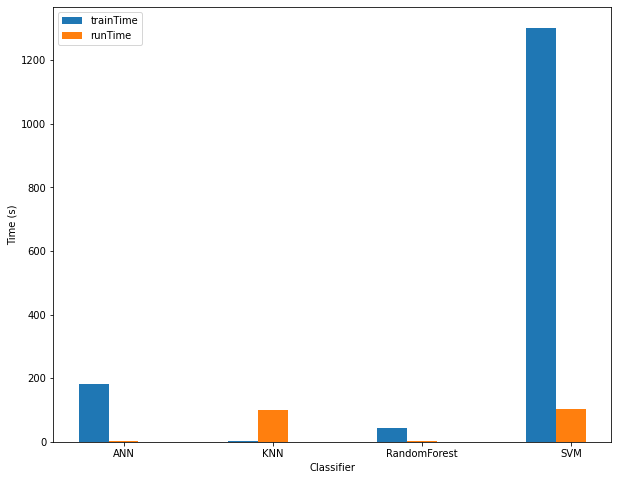

Classifier      trainTime(s)    runTime(s)
------------  --------------  ------------
ANN                181.656         1.1562
KNN                  1.02508      99.9126
RF                  43.1772        1.16537
SVM               1302.22        102.141


In [16]:
x = ["ANN", "KNN", "RandomForest", "SVM"]
trainTime = [results["ANN"]["trainTime"], results["KNN"]["trainTime"], results["RF"]["trainTime"], results["SVM"]["trainTime"]]
runTime = [results["ANN"]["runTime"], results["KNN"]["runTime"], results["RF"]["runTime"], results["SVM"]["runTime"]]

w = 0.2

bar1 = np.arange(len(x))
bar2 = [j+w for j in bar1]
plt.bar(bar1, trainTime, w, label="trainTime")
plt.bar(bar2, runTime, w, label="runTime")

plt.gcf().set_size_inches(10,8)
plt.xlabel("Classifier")
plt.ylabel("Time (s)")
plt.xticks(bar2, x)
plt.legend()
plt.show()

headers = ["Classifier", "trainTime(s)", "runTime(s)"]
data = [("ANN", results["ANN"]["trainTime"], results["ANN"]["runTime"]),
        ("KNN", results["KNN"]["trainTime"], results["KNN"]["runTime"]),
        ("RF", results["RF"]["trainTime"], results["RF"]["runTime"]),
        ("SVM", results["SVM"]["trainTime"], results["SVM"]["runTime"])]
table = tabulate(data, headers=headers)
print(table)

### Ram Usage Analysis

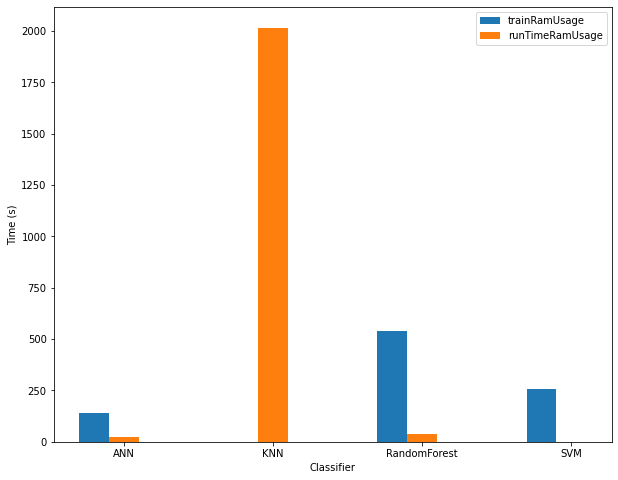

Classifier      trainRamUsage(Mb)    runTimeRamUsage(Mb)
------------  -------------------  ---------------------
ANN                        141.65                  23.89
KNN                          0.08                2016.64
RF                         538.25                  36.55
SVM                        257.71                   0.02


In [24]:
x = ["ANN", "KNN", "RandomForest", "SVM"]
trainRam = [results["ANN"]["trainRam"], results["KNN"]["trainRam"], results["RF"]["trainRam"], results["SVM"]["trainRam"]]
runTimeRam = [results["ANN"]["runTimeRam"], results["KNN"]["runTimeRam"], results["RF"]["runTimeRam"], results["SVM"]["runTimeRam"]]

w = 0.2

bar1 = np.arange(len(x))
bar2 = [j+w for j in bar1]
plt.bar(bar1, trainRam, w, label="trainRamUsage")
plt.bar(bar2, runTimeRam, w, label="runTimeRamUsage")

plt.gcf().set_size_inches(10,8)
plt.xlabel("Classifier")
plt.ylabel("Time (s)")
plt.xticks(bar2, x)
plt.legend()
plt.show()

headers = ["Classifier", "trainRamUsage(Mb)", "runTimeRamUsage(Mb)"]
data = [("ANN", results["ANN"]["trainRam"], results["ANN"]["runTimeRam"]),
        ("KNN", results["KNN"]["trainRam"], results["KNN"]["runTimeRam"]),
        ("RF", results["RF"]["trainRam"], results["RF"]["runTimeRam"]),
        ("SVM", results["SVM"]["trainRam"], results["SVM"]["runTimeRam"])]
table = tabulate(data, headers=headers)
print(table)

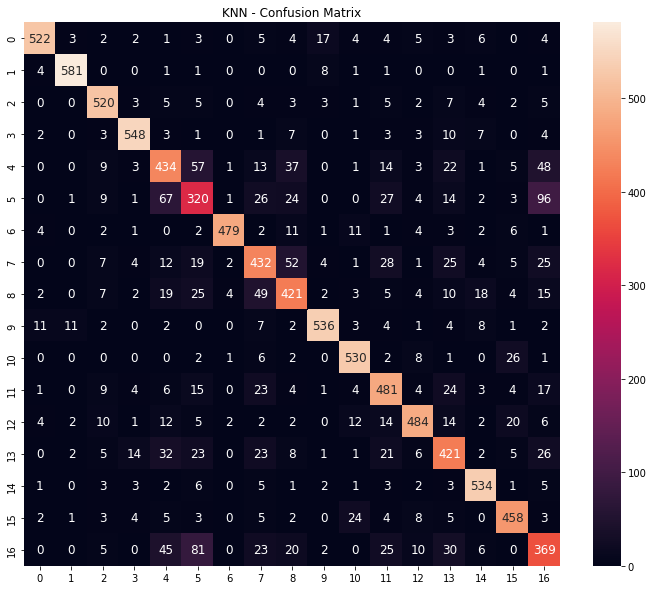

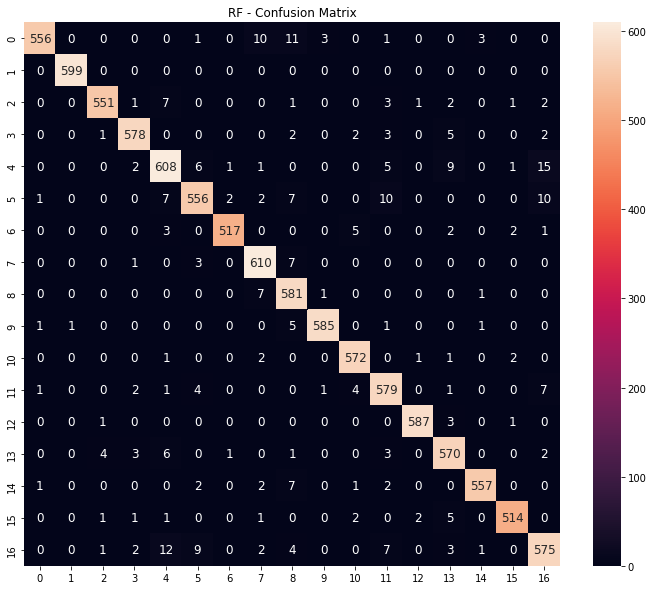

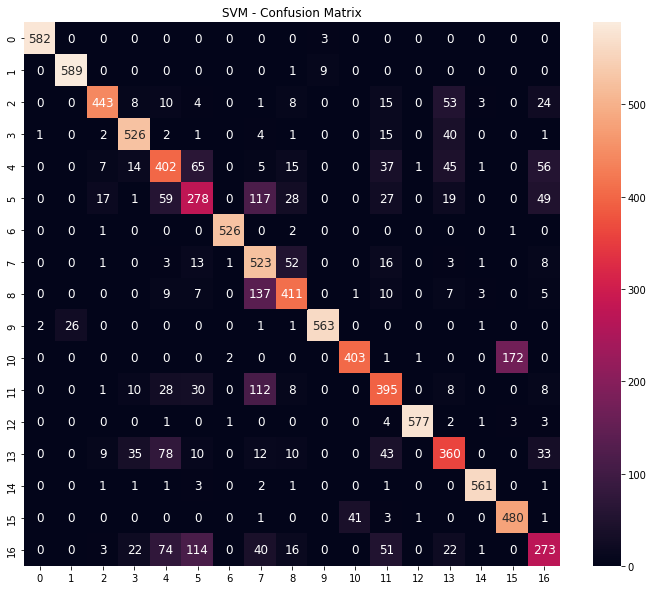

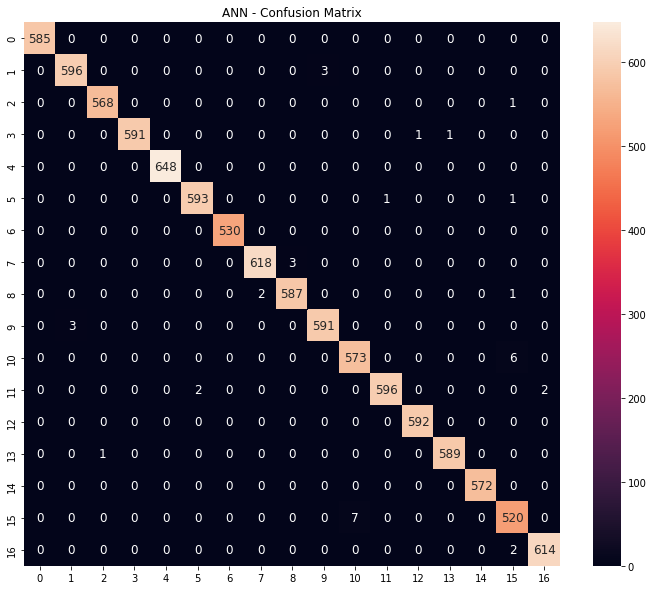

In [14]:
import seaborn as sns

for name in classifiers.keys():
    cm = results[name]["cm"]
    if cm is None:
        continue
    fig, ax = plt.subplots(figsize=(12,10))
    ax.set_title(name + " - Confusion Matrix")
    sns.heatmap(cm, annot=True, ax=ax, fmt='d', annot_kws={"size": 12})
